# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import Data

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df['charges'] = np.log(df['charges'])

In [4]:
# adding a BMI category column 
bins = [0, 18.5, 25, 30, np.inf] # np.inf for the upper bound of the last category
labels = ['Underweight', 'Healthy', 'Overweight', 'Obese']

# Create the 'bmi_category' column
df['bmi_category'] = pd.cut(df['bmi'], bins=bins, labels=labels, right=True)

In [5]:
# adding has_children column -> For some reason I can't have True False in the has_children column for the one hot encoder
df['has_children'] = df['children'].apply(lambda x: 'Yes' if x > 0 else 'No')

In [6]:
df

,age,sex,bmi,children,smoker,region,charges,bmi_category,has_children
0,19,female,27.900,0,yes,southwest,9.734176,Overweight,No
1,18,male,33.770,1,no,southeast,7.453302,Obese,Yes
2,28,male,33.000,3,no,southeast,8.400538,Obese,Yes
3,33,male,22.705,0,no,northwest,9.998092,Healthy,No
4,32,male,28.880,0,no,northwest,8.260197,Overweight,No
...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,9.268661,Obese,Yes
1334,18,female,31.920,0,no,northeast,7.698927,Obese,No
1335,18,female,36.850,0,no,southeast,7.396233,Obese,No
1336,21,female,25.800,0,no,southwest,7.604867,Overweight,No


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           1338 non-null   int64   
 1   sex           1338 non-null   object  
 2   bmi           1338 non-null   float64 
 3   children      1338 non-null   int64   
 4   smoker        1338 non-null   object  
 5   region        1338 non-null   object  
 6   charges       1338 non-null   float64 
 7   bmi_category  1338 non-null   category
 8   has_children  1338 non-null   object  
dtypes: category(1), float64(2), int64(2), object(4)
memory usage: 85.3+ KB


# Feature Selection

In [8]:
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region', 'bmi_category', 'has_children']

target = 'charges'

In [9]:
df[categorical_features] = df[categorical_features].astype('category')

# Train Test Split

In [10]:
X = df[numerical_features+categorical_features]
y = df[target]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Outlier Removal

In [12]:
# the only outliers I detected where the 18 year old people with kids. for now I didn't remove them

# Numerical Transformer

In [13]:
numeric_transformer = Pipeline(steps=[
    ('mean_imputer', SimpleImputer(strategy='mean')),  # Impute with median
    ('scaler', StandardScaler())  # Scale with StandardScaler
])

# Categorical Transformer

In [14]:
categorical_transformer = Pipeline(steps=[
    ('most_frequent_imputer', SimpleImputer(strategy='most_frequent')),  # Impute with the most frequent value
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))  # One-Hot Encoding
])

# Preprocessing Pipeline

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num_transformer', numeric_transformer, numerical_features),
        ('cat_transformer', categorical_transformer, categorical_features),
    ])

# Modeling Functions

In [16]:
def show_results(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {'mae': mae, 'mse': mse, 'rmse': rmse, 'mape': mape, 'r2': r2}

In [17]:
def show_comparison(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    
    min_val = min(min(y_test), min(y_pred_lr))
    max_val = max(max(y_test), max(y_pred_lr))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    plt.legend()
    plt.show()

In [18]:
def get_output_df(X_test, y_pred, y_test):
    df_compare = X_test.copy()
    
    df_compare['pred'] = y_pred
    df_compare['target'] = y_test.values

    df_compare['absolute_error'] = (df_compare['pred'] - df_compare['target']).abs()
    
    return df_compare

In [19]:
# function to plot the feature importances of tree based algorithms
def show_feature_importances(model):
    feature_importances = model.named_steps['regressor'].feature_importances_
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print(importance_df)
    
    # Plotting the horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importances')
    plt.gca().invert_yaxis()  # To display the most important feature at the top
    plt.tight_layout()

In [20]:
# Variable that staores the test scores of the different models to decide which one to use
report_ac = {}

# Modeling Parametrizations

In [21]:
metric_to_optimize = 'neg_mean_squared_error'

In [22]:
param_grid_lr = {
    # Linear Regression has no hyperparameters
}

param_grid_ridge = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100]
}

param_grid_lasso = {
    'regressor__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
}

param_grid_elastic_net = {
    'regressor__alpha': [0.01, 0.1, 1, 10],
    'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

param_grid_svr = {
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.01, 0.1, 0.5],
    'regressor__kernel': ['linear', 'rbf']
}

param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 10],
    'regressor__weights': ['uniform', 'distance']
}

param_grid_mlp = {
    'regressor__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'regressor__activation': ['relu', 'tanh'],
    'regressor__alpha': [0.0001, 0.001, 0.01],
    'regressor__learning_rate': ['constant', 'adaptive']
}

param_grid_rf = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [5, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

param_grid_gb = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1, 0.2],
    'regressor__max_depth': [3, 5]
}

# Linear Regression

In [23]:
lr_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [24]:
grid_search_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [25]:
grid_search_lr.fit(X_train, y_train)

lr_model = grid_search_lr.best_estimator_

y_pred_lr = np.exp(lr_model.predict(X_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [26]:
print("Best hyperparameters:", grid_search_lr.best_params_)

results = show_results(np.exp(y_test), y_pred_lr)
print(results)

report_ac['lr'] = results

Best hyperparameters: {}
{'mae': 4542.103378395764, 'mse': 73713579.39221388, 'rmse': 8585.661267032021, 'mape': 0.2807408677576718, 'r2': 0.4744155960510902}


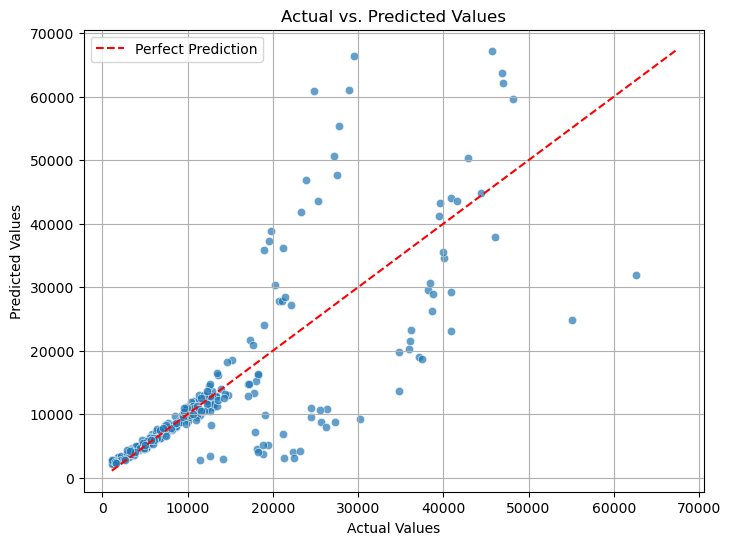

In [27]:
show_comparison(np.exp(y_test), y_pred_lr)

# Ridge Regression

In [28]:
ridge_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

In [29]:
grid_search_ridge = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid_ridge,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [30]:
grid_search_ridge.fit(X_train, y_train)

ridge_model = grid_search_ridge.best_estimator_

y_pred_ridge = np.exp(ridge_model.predict(X_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [31]:
print("Best hyperparameters:", grid_search_ridge.best_params_)

results = show_results(np.exp(y_test), y_pred_ridge)
print(results)

report_ac['ridge'] = results

Best hyperparameters: {'regressor__alpha': 1}
{'mae': 4519.142400526631, 'mse': 72762910.9739229, 'rmse': 8530.11787573436, 'mape': 0.2806196907852189, 'r2': 0.48119394677154503}


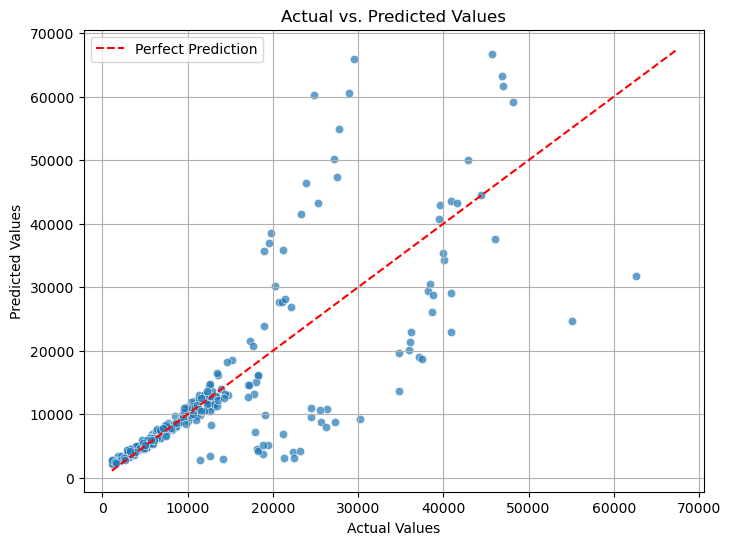

In [32]:
show_comparison(np.exp(y_test), y_pred_ridge)

# Lasso Regression

In [33]:
lasso_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

In [34]:
grid_search_lasso = GridSearchCV(
    estimator=lasso_model,
    param_grid=param_grid_lasso,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [35]:
grid_search_lasso.fit(X_train, y_train)

lasso_model = grid_search_lasso.best_estimator_

y_pred_lasso = np.exp(lasso_model.predict(X_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [36]:
print("Best hyperparameters:", grid_search_lasso.best_params_)

results = show_results(np.exp(y_test), y_pred_lasso)
print(results)

report_ac['lasso'] = results

Best hyperparameters: {'regressor__alpha': 0.001}
{'mae': 4528.826593446924, 'mse': 73164878.68322958, 'rmse': 8553.647098356909, 'mape': 0.2811634469542903, 'r2': 0.4783278811070554}


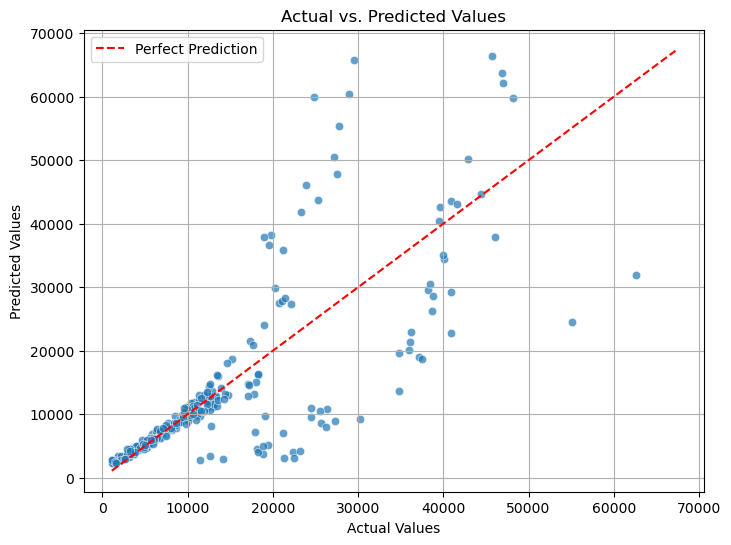

In [37]:
show_comparison(np.exp(y_test), y_pred_lasso)

# Elastic Net

In [38]:
elastic_net_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet())
])

In [39]:
grid_search_elastic_net = GridSearchCV(
    estimator=elastic_net_model,
    param_grid=param_grid_elastic_net,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [40]:
grid_search_elastic_net.fit(X_train, y_train)

elastic_net_model = grid_search_elastic_net.best_estimator_

y_pred_elastic_net = np.exp(elastic_net_model.predict(X_test))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [41]:
print("Best hyperparameters:", grid_search_elastic_net.best_params_)

results = show_results(np.exp(y_test), y_pred_elastic_net)
print(results)

report_ac['elastic_net'] = results

Best hyperparameters: {'regressor__alpha': 0.01, 'regressor__l1_ratio': 0.5}
{'mae': 4397.459613446046, 'mse': 67334094.92345192, 'rmse': 8205.735489488552, 'mape': 0.2827668126138817, 'r2': 0.5199018900238088}


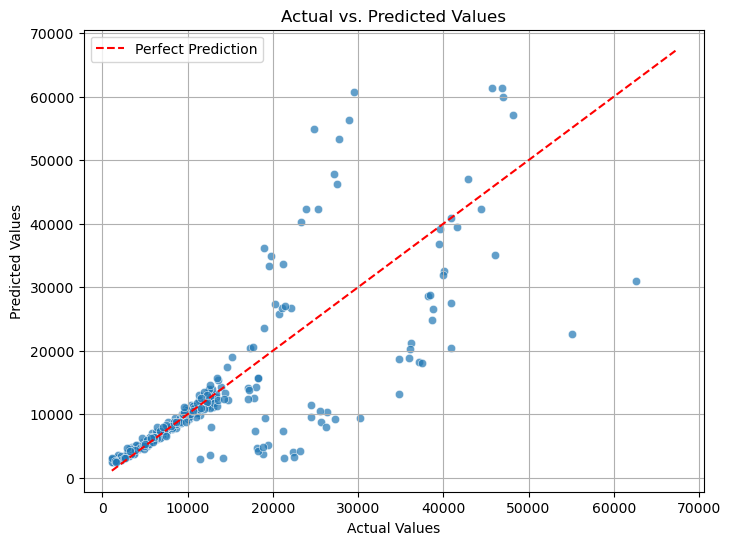

In [42]:
show_comparison(np.exp(y_test), y_pred_elastic_net)

# SVR

In [43]:
svr_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

In [44]:
grid_search_svr = GridSearchCV(
    estimator=svr_model,
    param_grid=param_grid_svr,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [45]:
grid_search_svr.fit(X_train, y_train)

svr_model = grid_search_svr.best_estimator_

y_pred_svr = np.exp(svr_model.predict(X_test))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [46]:
print("Best hyperparameters:", grid_search_svr.best_params_)

results = show_results(np.exp(y_test), y_pred_svr)
print(results)

report_ac['svr'] = results

Best hyperparameters: {'regressor__C': 10, 'regressor__epsilon': 0.01, 'regressor__kernel': 'rbf'}
{'mae': 2011.2077885760061, 'mse': 26589739.91785433, 'rmse': 5156.524015056492, 'mape': 0.09919662466344979, 'r2': 0.810412779828215}


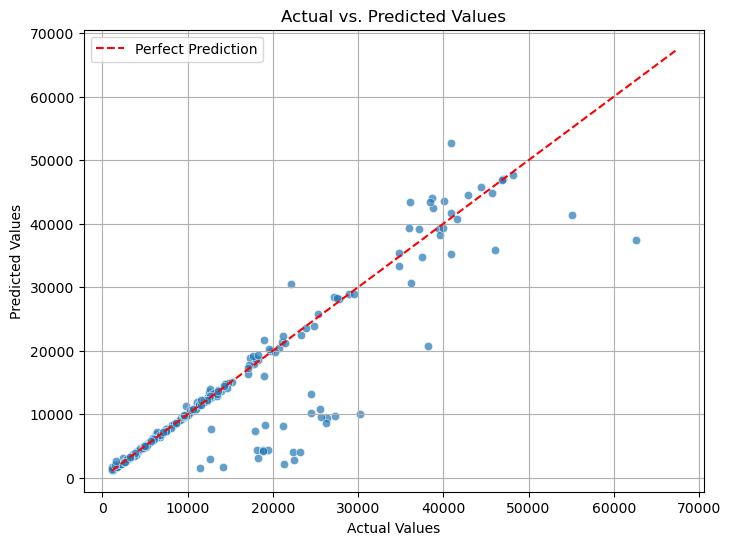

In [47]:
show_comparison(np.exp(y_test), y_pred_svr)

# KNN Regressor

In [48]:
knn_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

In [49]:
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid_knn,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [50]:
grid_search_knn.fit(X_train, y_train)

knn_model = grid_search_knn.best_estimator_

y_pred_knn = np.exp(knn_model.predict(X_test))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [51]:
print("Best hyperparameters:", grid_search_knn.best_params_)

results = show_results(np.exp(y_test), y_pred_knn)
print(results)

report_ac['knn'] = results

Best hyperparameters: {'regressor__n_neighbors': 5, 'regressor__weights': 'distance'}
{'mae': 4822.521907125361, 'mse': 76738644.97410809, 'rmse': 8760.05964443782, 'mape': 0.33770771972123426, 'r2': 0.4528466083031669}


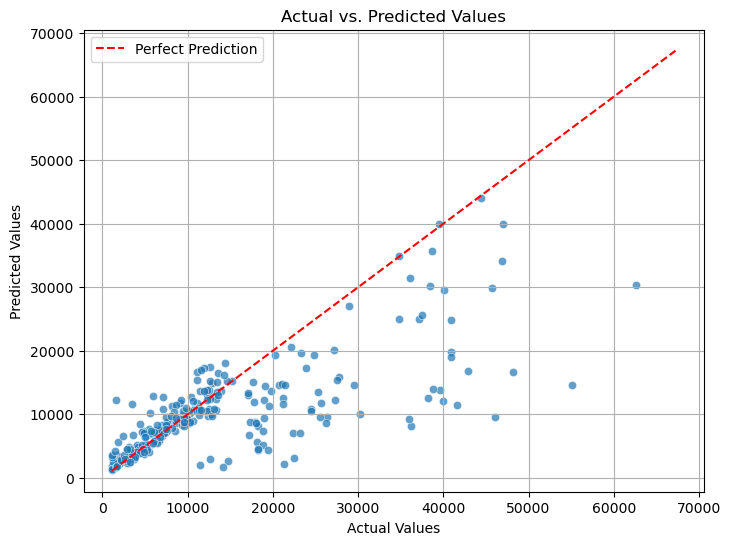

In [52]:
show_comparison(np.exp(y_test), y_pred_knn)

# MLP Regressor

In [53]:
mlp_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', MLPRegressor())
])

In [54]:
grid_search_mlp = GridSearchCV(
    estimator=mlp_model,
    param_grid=param_grid_mlp,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [55]:
grid_search_mlp.fit(X_train, y_train)

mlp_model = grid_search_mlp.best_estimator_

y_pred_mlp = np.exp(mlp_model.predict(X_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [56]:
print("Best hyperparameters:", grid_search_mlp.best_params_)

results = show_results(np.exp(y_test), y_pred_mlp)
print(results)

report_ac['mlp'] = results

Best hyperparameters: {'regressor__activation': 'tanh', 'regressor__alpha': 0.001, 'regressor__hidden_layer_sizes': (100, 50), 'regressor__learning_rate': 'adaptive'}
{'mae': 2976.25329617985, 'mse': 30773070.889181554, 'rmse': 5547.348095187605, 'mape': 0.18470366141750066, 'r2': 0.780585256416453}


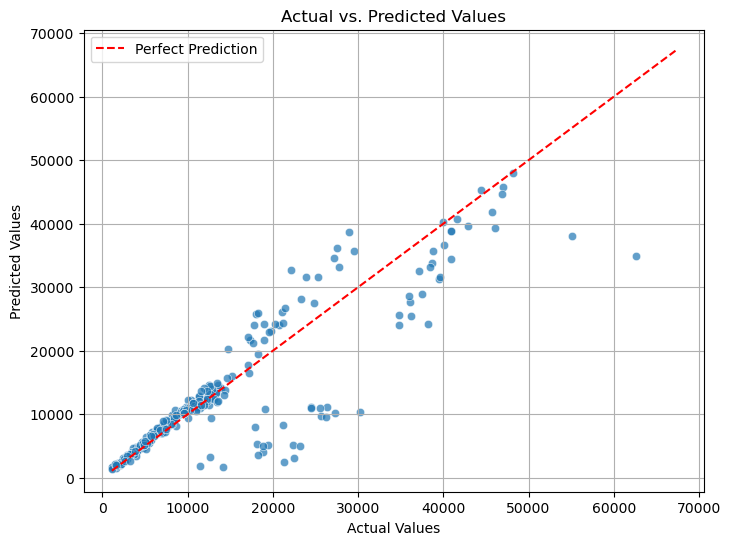

In [57]:
show_comparison(np.exp(y_test), y_pred_mlp)

# Random Forest Regressor

In [58]:
rf_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [59]:
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [60]:
grid_search_rf.fit(X_train, y_train)

rf_model = grid_search_rf.best_estimator_

y_pred_rf = np.exp(rf_model.predict(X_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [61]:
print("Best hyperparameters:", grid_search_rf.best_params_)

results = show_results(np.exp(y_test), y_pred_rf)
print(results)

report_ac['rf'] = results

Best hyperparameters: {'regressor__max_depth': 5, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
{'mae': 2246.080553722487, 'mse': 23153206.678598505, 'rmse': 4811.777912435123, 'mape': 0.1846738976314392, 'r2': 0.8349155687186386}


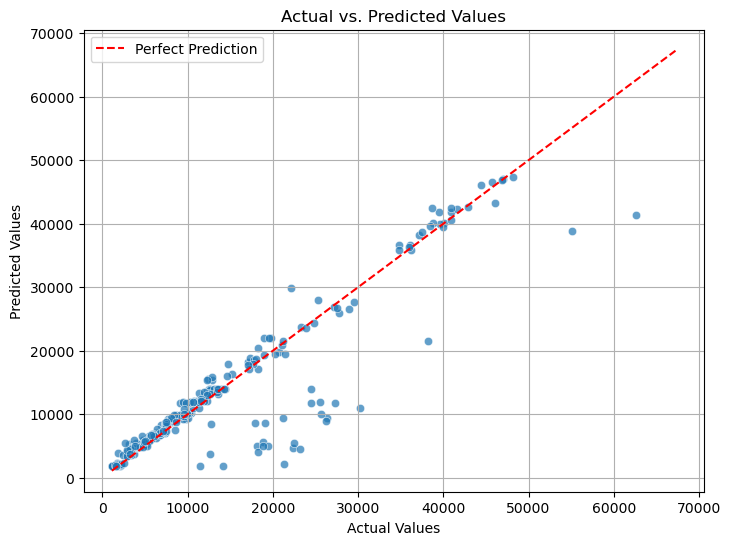

In [62]:
show_comparison(np.exp(y_test), y_pred_rf)

                                      Feature  Importance
4                 cat_transformer__smoker_yes    0.513008
0                        num_transformer__age    0.408361
1                        num_transformer__bmi    0.029716
2                   num_transformer__children    0.022409
10        cat_transformer__bmi_category_Obese    0.011435
13          cat_transformer__has_children_Yes    0.007632
5           cat_transformer__region_northeast    0.002644
6           cat_transformer__region_northwest    0.002070
3                   cat_transformer__sex_male    0.001538
7           cat_transformer__region_southeast    0.000406
11   cat_transformer__bmi_category_Overweight    0.000353
8           cat_transformer__region_southwest    0.000297
12  cat_transformer__bmi_category_Underweight    0.000067
9       cat_transformer__bmi_category_Healthy    0.000065


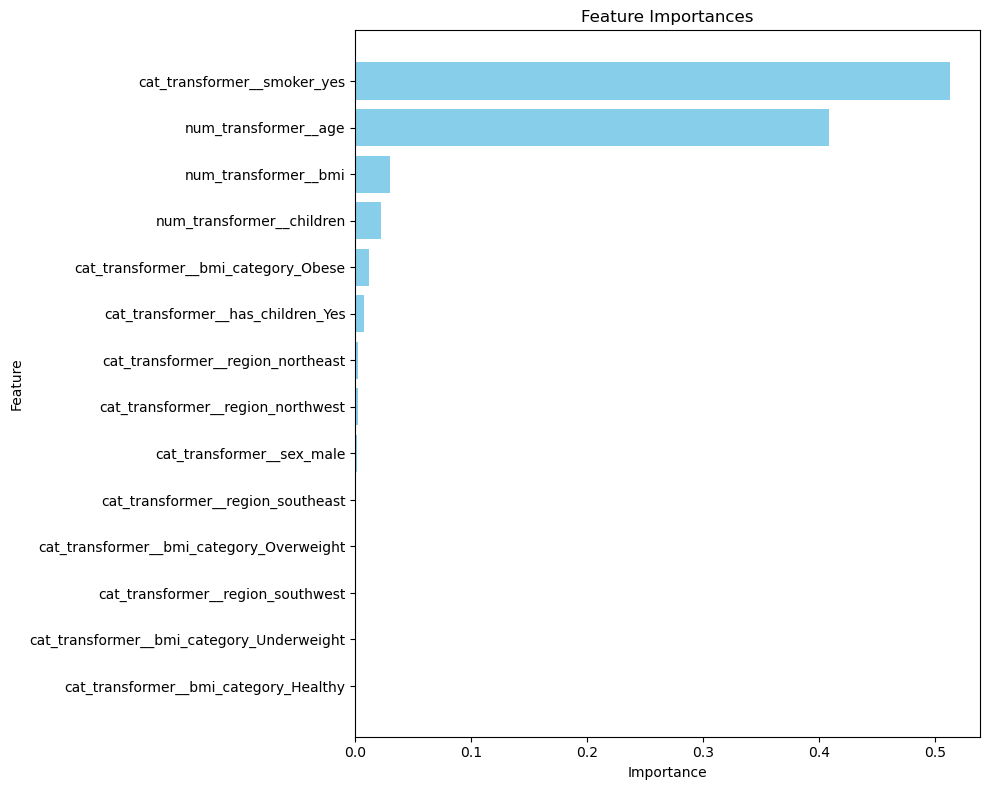

In [63]:
show_feature_importances(rf_model)

# Gradient Booster Regressor

In [64]:
gb_model = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

In [65]:
grid_search_gb = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid_gb,
    cv=5,
    scoring=metric_to_optimize,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

In [66]:
grid_search_gb.fit(X_train, y_train)

gb_model = grid_search_gb.best_estimator_

y_pred_gb = np.exp(gb_model.predict(X_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [67]:
print("Best hyperparameters:", grid_search_gb.best_params_)

results = show_results(np.exp(y_test), y_pred_gb)
print(results)

report_ac['gb'] = results

Best hyperparameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
{'mae': 2274.2127866687833, 'mse': 24151223.902977645, 'rmse': 4914.3894740829855, 'mape': 0.17068306524041776, 'r2': 0.8277996167823599}


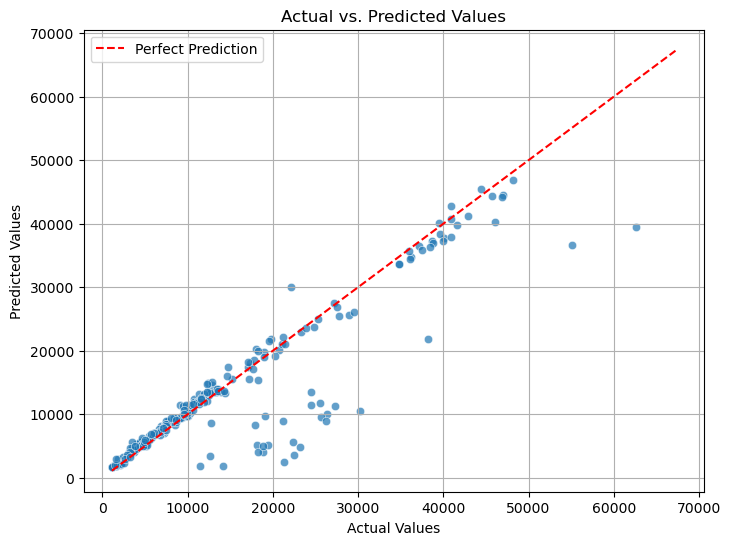

In [68]:
show_comparison(np.exp(y_test), y_pred_gb)

In [69]:
pd.set_option('display.max_rows', None)

get_output_df(X_test, y_pred_gb, y_test).sort_values(by=['absolute_error'], ascending=False)

,age,bmi,children,sex,smoker,region,bmi_category,has_children,pred,target,absolute_error
39,60,39.900,0,male,yes,southwest,Obese,No,46871.314546,10.782561,46860.531984
706,51,38.060,0,female,yes,southeast,Obese,No,45442.258798,10.701004,45431.557794
109,63,35.090,0,male,yes,southeast,Obese,No,44511.753145,10.759084,44500.994061
668,62,32.015,0,male,yes,northeast,Obese,No,44370.724462,10.730077,44359.994385
420,64,33.880,0,male,yes,southeast,Obese,No,44201.965372,10.755544,44191.209828
1124,23,42.750,1,female,yes,northeast,Obese,Yes,42851.788116,10.618988,42841.169128
271,50,34.200,2,male,yes,southwest,Obese,Yes,41262.053264,10.665620,41251.387643
1152,43,32.560,3,female,yes,southeast,Obese,Yes,40731.646922,10.619894,40721.027028
860,37,47.600,2,female,yes,southwest,Obese,Yes,40233.374391,10.738861,40222.635530
123,44,31.350,1,male,yes,northeast,Obese,Yes,40184.034441,10.585485,40173.448956


                                      Feature  Importance
4                 cat_transformer__smoker_yes    0.510760
0                        num_transformer__age    0.410424
1                        num_transformer__bmi    0.026085
2                   num_transformer__children    0.022620
10        cat_transformer__bmi_category_Obese    0.013862
13          cat_transformer__has_children_Yes    0.009900
5           cat_transformer__region_northeast    0.003048
3                   cat_transformer__sex_male    0.002233
8           cat_transformer__region_southwest    0.000479
7           cat_transformer__region_southeast    0.000267
11   cat_transformer__bmi_category_Overweight    0.000173
6           cat_transformer__region_northwest    0.000096
12  cat_transformer__bmi_category_Underweight    0.000036
9       cat_transformer__bmi_category_Healthy    0.000016


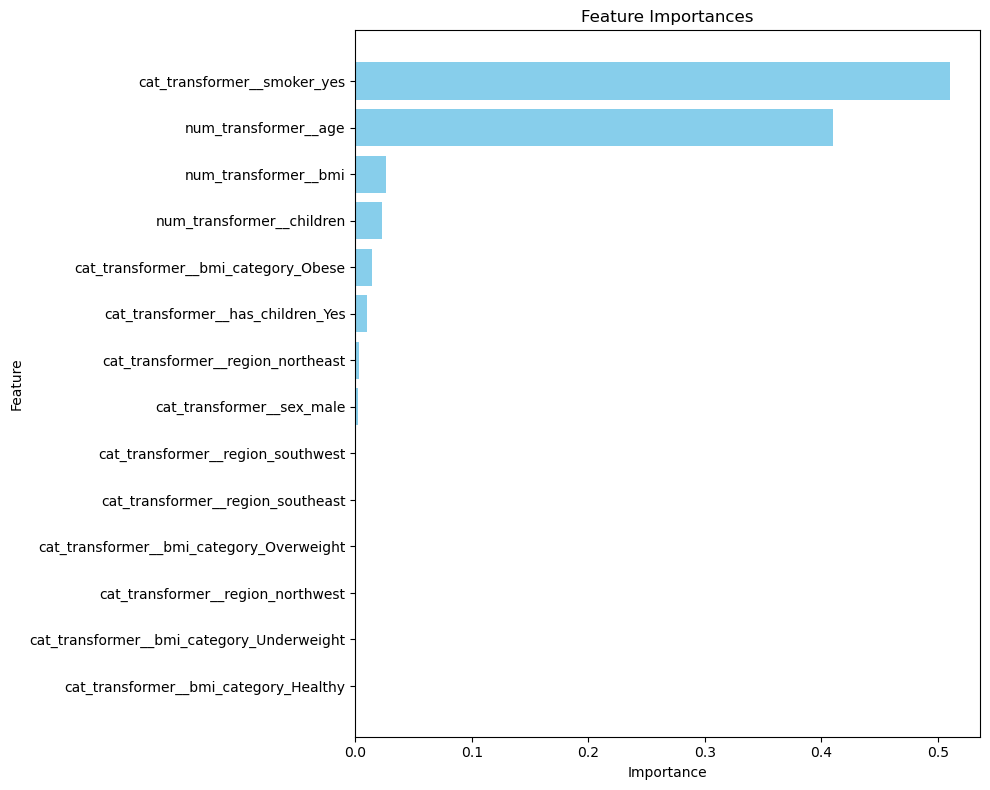

In [70]:
show_feature_importances(gb_model)

# Model Evaluation

In [71]:
report_ac

{'lr': {'mae': 4542.103378395764,
  'mse': 73713579.39221388,
  'rmse': 8585.661267032021,
  'mape': 0.2807408677576718,
  'r2': 0.4744155960510902},
 'ridge': {'mae': 4519.142400526631,
  'mse': 72762910.9739229,
  'rmse': 8530.11787573436,
  'mape': 0.2806196907852189,
  'r2': 0.48119394677154503},
 'lasso': {'mae': 4528.826593446924,
  'mse': 73164878.68322958,
  'rmse': 8553.647098356909,
  'mape': 0.2811634469542903,
  'r2': 0.4783278811070554},
 'elastic_net': {'mae': 4397.459613446046,
  'mse': 67334094.92345192,
  'rmse': 8205.735489488552,
  'mape': 0.2827668126138817,
  'r2': 0.5199018900238088},
 'svr': {'mae': 2011.2077885760061,
  'mse': 26589739.91785433,
  'rmse': 5156.524015056492,
  'mape': 0.09919662466344979,
  'r2': 0.810412779828215},
 'knn': {'mae': 4822.521907125361,
  'mse': 76738644.97410809,
  'rmse': 8760.05964443782,
  'mape': 0.33770771972123426,
  'r2': 0.4528466083031669},
 'mlp': {'mae': 2976.25329617985,
  'mse': 30773070.889181554,
  'rmse': 5547.34809

# Notes

Using the log of the charges to normalize the target distribution improved slighlty the results of the regressors. Mainly the ones that already had good results. For the linear regression the small values had way better results but high values of charge had way worse results showing heteroscedasticity